In [1]:
import os
import re
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import ast
import json
from glob import glob

In [2]:
visdrone_categories = ['bg','pedestrian', 'person', 'car', 'van', 'bus', 'truck', 'motor', 'bicycle', 'awning-tricycle', 'tricycle','empty_0','empty_1']


In [3]:
path_visDrone = '/home/mvlab/Downloads/dataset/VisDrone2019/VisDrone2019-DET-train/'
path_visDrone_annotation = path_visDrone + 'annotations/'
path_visDrone_image = path_visDrone + 'images/'
os.path.isdir(path_visDrone_annotation), os.path.isdir(path_visDrone_image)


(True, True)

In [4]:
def load_visdrone_data(path_visDrone, pedestrian_only=True):
    
    list_image_arr = []
    list_cbbox = []
    path_visDrone_annotation = path_visDrone + 'annotations/'
    path_visDrone_image = path_visDrone + 'images/'
    os.path.isdir(path_visDrone_annotation), os.path.isdir(path_visDrone_image)
    list_annotation = glob(path_visDrone_annotation+'*.*')
    list_image_path = glob(path_visDrone_image+'*.*')
    len(list_annotation), len(list_image_path), list_annotation[0]
    
    for i in range(len(list_annotation)):
        path_annotation = list_annotation[i]
        
        df = pd.read_csv(path_annotation, header=None)
                
        cls = np.array(df.iloc[:, 5])
        bbox_xywh = np.array(df.iloc[:, :4])
        x0 = bbox_xywh[:, 0]
        y0 = bbox_xywh[:, 1]
        w = bbox_xywh[:, 2]
        h = bbox_xywh[:, 3]
        x1 = x0 + w
        y1 = y0 + h
        
        file_name_annotation = path_annotation.split('/')[-1].split('.')[0]
        file_name_image = path_visDrone_image+file_name_annotation+'.jpg'
                
        if pedestrian_only:            
            human_mask = np.logical_and(cls > 0, cls < 3)
            vehicle_mask = cls > 2
            is_human_contain = np.any(human_mask)
            human_count = np.sum(human_mask)
            if not is_human_contain or human_count < 30:#30:651
                continue
            
            cls = np.where(human_mask, 1.0, 0.0)
            #cls = np.where(vehicle_mask, 3.0, cls)        
        
        img = Image.open(file_name_image)
        img_arr = np.array(img)
        img_h, img_w, img_c = img_arr.shape
        cbbox_norm = np.stack((x0/img_w, y0/img_h, x1/img_w, y1/img_h, cls), axis=1)
        
        if pedestrian_only:
            cbbox_norm = cbbox_norm[human_mask]
            
            box_height = cbbox_norm[:, 3] - cbbox_norm[:, 1]
            box_height_max = np.max(box_height)
            if box_height_max < 0.05 or box_height_max > 0.2:
                continue
                
        list_image_arr.append(img_arr)
        list_cbbox.append(cbbox_norm)
        if len(list_image_arr)>1000:
            break
        if i%100==0:
            print(len(list_annotation), i, file_name_annotation, len(list_image_arr))
    return list_image_arr, list_cbbox

In [5]:
list_visdrone_image_arr, list_visdrone_cbbox = load_visdrone_data(path_visDrone)
print(len(list_visdrone_image_arr))

6471 1200 0000050_00500_d_0000104 100
6471 1500 9999937_00000_d_0000179 125
6471 2200 0000351_02941_d_0000534 181
6471 3000 0000036_00500_d_0000046 242
6471 3300 0000288_03601_d_0000802 274
6471 3800 0000358_02353_d_0000692 313
6471 4800 0000309_04201_d_0000354 418
6471 5700 0000205_01665_d_0000200 505
553


(array([2102., 2609., 3207., 3943., 5123., 5135., 3879., 2873., 2029.,
        1504.]),
 array([0.        , 0.09971429, 0.19942857, 0.29914286, 0.39885714,
        0.49857143, 0.59828571, 0.698     , 0.79771429, 0.89742857,
        0.99714286]),
 <a list of 10 Patch objects>)

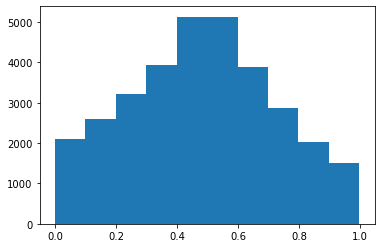

In [6]:
visdrone_cbbox = np.concatenate(list_visdrone_cbbox, 0)
visdrone_cbbox.shape
plt.hist(visdrone_cbbox[:, 0])

In [7]:
input_list_all = list_visdrone_image_arr
bbox_list_all = list_visdrone_cbbox
print('extend', len(list_visdrone_image_arr), len(input_list_all), len(bbox_list_all))

extend 553 553 553


In [8]:
colors = np.random.rand(len(visdrone_categories), 3)
def visualize_detections_simple(
    image, boxes, classes, figsize=(12, 12),
):
    """Visualize Detections"""
    image = np.array(image, dtype=np.uint8)
    img_h, img_w, img_c = image.shape
    plt.figure(figsize=figsize)
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    box_min_width = np.min(boxes_width)
    box_mean_width = np.mean(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, height:min:%d mean:%d max:%d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_mean_width, box_max_width))
    plt.title(title)
    
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        cls = int(cls)
        color = colors[cls]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=1
        )
        ax.add_patch(patch)
        ax.text(
            x1, y1, str(cls), bbox={"facecolor": color, "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,
        )
    plt.show()
    return ax

In [11]:
def display_data(X, BBOX, stride=1):
    for i in range(len(X)):
        if i%stride==0:
            img_arr = input_list_all[i]
            sample_box = bbox_list_all[i]
            label = sample_box[:, 4]
            bbox = sample_box[:, :4]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h), dtype=np.float)
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale
            #print('bbox_norm', bbox, bbox_norm)
            ax = visualize_detections_simple(img_arr,bbox_norm,label)

In [ ]:
display_data(input_list_all, bbox_list_all, 1)